# Praca Domowa 3

Autor: Paulina Przybyłek

## Wczytanie danych i pakietów

In [33]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import category_encoders as ce

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import preprocessing

from sklearn.metrics import recall_score, precision_score, roc_curve, roc_auc_score, plot_confusion_matrix, plot_precision_recall_curve, f1_score
from sklearn.metrics import r2_score, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

Zaczniemy od wczytania danych i krótkiemu przyjrzenia się im. Wedle treści zadania dane powinny nie mieć braków i być gotowe do użycia.

In [39]:
data = pd.read_csv('/home/paulinaprzybylek/Dokumenty/ml/2020L-WUM/Prace_domowe/Praca_domowa3/australia.csv')
data.head(5)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,17.9,35.2,0.0,12.0,12.3,48.0,6.0,20.0,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,0,0
1,18.4,28.9,0.0,14.8,13.0,37.0,19.0,19.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,0,0
2,19.4,37.6,0.0,10.8,10.6,46.0,30.0,15.0,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,0,0
3,21.9,38.4,0.0,11.4,12.2,31.0,6.0,6.0,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,0,0
4,24.2,41.0,0.0,11.2,8.4,35.0,17.0,13.0,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,0,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56420 entries, 0 to 56419
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        56420 non-null  float64
 1   MaxTemp        56420 non-null  float64
 2   Rainfall       56420 non-null  float64
 3   Evaporation    56420 non-null  float64
 4   Sunshine       56420 non-null  float64
 5   WindGustSpeed  56420 non-null  float64
 6   WindSpeed9am   56420 non-null  float64
 7   WindSpeed3pm   56420 non-null  float64
 8   Humidity9am    56420 non-null  float64
 9   Humidity3pm    56420 non-null  float64
 10  Pressure9am    56420 non-null  float64
 11  Pressure3pm    56420 non-null  float64
 12  Cloud9am       56420 non-null  float64
 13  Cloud3pm       56420 non-null  float64
 14  Temp9am        56420 non-null  float64
 15  Temp3pm        56420 non-null  float64
 16  RainToday      56420 non-null  int64  
 17  RainTomorrow   56420 non-null  int64  
dtypes: flo

Mamy 18 kolumn, z czego większość o ciągłych zmiennych. Braki danych nie występują, a zmiennych nie musimy kodować. Przypomnijmy sobie o czym są kolumny w naszym zbiorze. Kolumny:

+ MinTemp - Minimalna temperatura [C]
+ MaxTemp - Maksymalna temperatura [C]
+ Rainfall - Suma opadów [mm]
+ Evaporation - Miara odparowywania [mm]
+ Sunshine - Suma czasu nasłonecznienia [h]
+ WindGustSpeed - Najwyższa prędkość wiatru [km/h]
+ WindSpeed9am - Prędkość wiatru o 9:00 [km/h]
+ WindSpeed3pm - Prędkość wiatru o 15:00 [km/h]
+ Humidity9am - Wilgotność o 9:00 [%]
+ Humidity3pm - Wilgotność o 15:00 [%]
+ Pressure9am - Ciśnienie atmosferyczne o 9:00 [hPa]
+ Pressure3pm - Ciśnienie atmosferyczne o 15:00 [hPa]
+ Cloud9am - Zachmurzenie o 9:00 [skala: 0 - słońce, 8 - całkowite zachmurzenie]
+ Cloud3pm - Zachmurzenie o 15:00 [skala: 0 - słońce, 8 - całkowite zachmurzenie]
+ Temp9am - Temperatura o 9:00 [C]
+ Temp3pm - Temperatura o 15:00 [C]
+ RainToday - Czy dzisiaj padał deszcz [0 - nie, 1 - tak]
+ RainTomorrow - Czy jutro będzie padał deszcz [0 - nie, 1 - tak]

Zmienną celu jest RainTomorrow i to właśnie, czyli czy następnego dnia będzie padał deszcz czy też nie, chcemy przewidywać. 

Zadanie polega na wytrenowaniu trzech modeli klasyfikacyjnych i sprawdzenia ich trzeba różnymi miarami oraz wyboru najlepszego klasyfikatora. Zacznijmy od wyboru miar, jakie zamierzamy stosować. W tym celu sprawdźmy czy nasz zbiór jest zblilansowany.

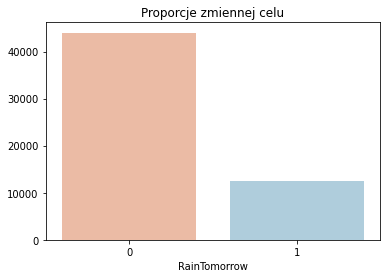

In [7]:
pl = sns.countplot(x='RainTomorrow', data=data, palette='RdBu')
pl.set_ylabel('')
pl.set_title('Proporcje zmiennej celu')
pl

Jak widać zbiór danych nie jest zbilansowany, więc nie wykorzystamy miary accuracy. Najlepiej będzie sprawdzić **recall** i **precision**, do tego wykorzystamy jeszcze miarę **AUC**. Możliwe, że podczas pracy okaże się, że warto będzie sprawdzić też inne miary.

## Podział na zbiór treningowy i testowy

In [8]:
# dzielimy zbiór na dwie części - z i bez kolumny ze zmienną celu
y = np.array(data['RainTomorrow'])
X = data.drop(['RainTomorrow'],axis=1)

# podział na zbiór treningowy i testowy
data_train, data_test, target_train, target_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [9]:
def np_counts(X):
    unique, counts = np.unique(X, return_counts=True)
    print(np.asarray((unique, counts)).T)

np_counts(target_train)
np_counts(target_test)

[[    0 35207]
 [    1  9929]]
[[   0 8786]
 [   1 2498]]


Treningowy zbiór zawiera 80% danych. Oczywiście podział jest odpowiedni względem zmiennej celu. Dodatkowo warto byłoby jeszcze dla pewności przesklalować dane.

In [10]:
std_scaler = preprocessing.StandardScaler(copy=False)
data_train = std_scaler.fit_transform(data_train) 
data_test = std_scaler.transform(data_test)

## Uczenie maszynowe

Modele, na których wytrenujemy nasz zbiór to:

+ Random Forest
+ Gradient Boosting
+ SVM

Najpierw wytrenujemy wszystkie modele a dopiero na końcu zrobimy wspólne podsumowanie wyników i zdecydujemy, który klasyfikator wypadł najlepiej.

Funkcje pomocnicze:

In [11]:
# tworzymy pomocniczą funkcję to wyboru parametrów
def parameter_search(model, param):
    
    cvr = GridSearchCV(model,param_grid = param, cv = 5)
    cvr.fit(data_train,target_train)
    
    # zobaczmy najlepszy wynik
    print(f"Score: {cvr.best_score_}")
    
    # a teraz jakie to parametry są najlepsze
    print(f"Best parameters: {cvr.best_params_}")

In [12]:
# tworzenie funkcji pomocniczej do przewidywania zmiennej (uczenia maszynowanego dla wybranego modelu)
def data_ml(model):
    
    #trenowanie modelu
    model.fit(data_train, target_train)
    # predykcja 
    predict_class = model.predict(data_test)
    predict_proba = model.predict_proba(data_test)[:, 1]
    
    return predict_class, predict_proba

### Model I - Random Forest

Pierwszym modelem jakiego użyjemy jest las losowy. Hiperparametrów jest całkiem sporo, więc skupimy się na kilku wybranych:

+ n_estimators - liczba drzew w lesie (domyślnie 100)
+ criterion - typ podziału danych - Gini (jest domyślna) lub Entropia
+ max_depth - maksymalna głębokość drzewa - ważna składowa, drzewa należy przycinać, aby nie doszło do przeuczenia

Resztę parametrów pozostawiam domyślną - stosowanie bootstrap, min_samples_split=2 (minimalna ilość próbki zmiennych do podziału), min_smaples_leaf=1 (minimalna liczba próbki w liściu - chociaż nie chcemy doprowadzić do tego, aby liście miały po jednej wartości, ale to można w miarę zrobić za pomocą przycinania drzew) itd.


In [11]:
# wybieramy model lasu i ustawiamy ziarno losowości
rf = RandomForestClassifier(random_state = 0)
# będziemy stroić parametry
param_grid_rf = { 
    'n_estimators': [50, 100, 200, 300], 
    'criterion' :['gini', 'entropy'],
    'max_depth' : [6,8,10,12]
}
parameter_search(rf, param_grid_rf)

Score: 0.8583170883156173
Best parameters: {'criterion': 'entropy', 'max_depth': 12, 'n_estimators': 200}


Wybór parametrów nie był zbyt duży z powodu przeciążenia mojego komputera, jednak dla tych trzech parametrów kilka opcji zostało sprawdzonych i wybrane z nich najlepsze. 

In [13]:
# trenowanie modelu dla najlepszych parametrów
model_rf = RandomForestClassifier(n_estimators = 200, criterion = 'entropy', max_depth = 12, random_state = 0)
predict_class_rf, predict_proba_rf = data_ml(model_rf)

### Model II - GradientBoosting

Wykorzystamy zamiast XGBooost wbudowaną w sklearn metodę GradientBoostingClassifier. Jak poprzednio wybierzemy tylko kilka parametrów do dostrojenia, a resztę zostawimy domyślną:

+ loss - funkcja straty do optymalizacji - 'deviance' (domyślne), 'exponential'
+ learning_rate - wskaźnik uczenia się zmniejsza wkład każdego drzewa o daną wartość - domyślnie 0.1 (float)
+ subsample - część obserwacji wykorzystywana do podpróbkowania na każdym etapie - domyślnie 1.0 (czyli używamy wszytskich obserwacji)
+ max_features - liczba cech brana pod uwagę przy wyborze najlepszego podziału zmiennych - skupimy się na trzech: jeśli 'sqrt', to max_features=sqrt(n_features), jeśli 'log2', to max_features=log2(n_features), jeśli None to max_features=n_features

Learning_rate, subsample mają wpływ na n_estimators - który oznacza liczbę etapów boostingu, domyślnie jako 100, stąd wybrałam je do strojenia, rezygnując z innych także ciekawych parametrów.

In [16]:
# wybieramy model gradient boosting i ustawiamy ziarno losowości
gb = GradientBoostingClassifier(random_state = 0)
# będziemy stroić parametry jak poprzednio
param_grid_gb = { 
    'loss': ['deviance', 'exponential'],
    'learning_rate': [0.1, 0.4, 0.7],
    'subsample': [0.5 , 0.8, 1.0],
    'max_features' : [None, 'log2', 'sqrt']
}
parameter_search(gb, param_grid_gb)

Score: 0.8579404380272269
Best parameters: {'learning_rate': 0.4, 'loss': 'exponential', 'max_features': None, 'subsample': 1.0}


Max_features i subsample pozostały domyślne, dopasujmy teraz nasz model z parametrami i dokonajmy predykcji.

In [14]:
# trenowanie modelu dla najlepszych parametrów
model_gb = GradientBoostingClassifier(learning_rate = 0.4, loss = 'exponential', max_features = None, subsample = 1.0 , random_state = 0)
predict_class_gb, predict_proba_gb = data_ml(model_gb)

### Model III - SVM

Tutaj także skorzystamy z metody z pakietu sklearn - LinearSVC. Jest to klasyfikacja wektorowa, która ma wyznaczyć linię najlepiej oddzielającą klasy w naszym zbiorze. Zmiana niektórych parametrów może spowodować, że metoda będzie zachowywać się podobnie co SVC. Wybrane parametry:

+ penalty - określa normę stosowaną w penalizacji - 'l2' (domyślnie, stosowana w SVC), 'l1' (prowadzi do rzadkich wektorów)
+ loss - funkcja straty - 'hinge' (stosowana w SVC), 'squared_hinge' (domyślna)
+ C - parametr regularyzacji, siła regularyzacji jest odwrotnie proporcjonalna do C - domyślnie 1.0 (float)
+ class_weight - wagi klas - można ustawić tryb ‘balanced’

Reszta parametrów zostaje domyślna.

In [12]:
# wybieramy model wektorowej klasyfikacji i ustawiamy ziarno losowości
svm = LinearSVC(random_state = 0)
# będziemy stroić parametry jak poprzednio
param_grid_svm = { 
    'penalty': ['l1', 'l2'], 
    'loss' : ['hinge', 'squared_hinge'],
    'C': [0.5, 1.0, 1.5],
    'class_weight' : [None, 'balanced']
}
parameter_search(svm, param_grid_svm)

Score: 0.8542848513485783
Best parameters: {'C': 1.0, 'class_weight': None, 'loss': 'squared_hinge', 'penalty': 'l2'}


Jak możemy zauważyć - wagi klas bez ustawień a C, loss i penalty takie jak domyślne ustawione okazały się najlepsze przy tym ziarnie. (komentarz, dla wcześniej ustalonego ziarna lepsze były wartości domyślne dla SVC, ale miały nadal podobny score)

In [15]:
# trenowanie modelu dla najlepszych parametrów
model_svm = LinearSVC(penalty = 'l2', loss = 'squared_hinge', C = 1.0, class_weight = None, random_state = 0)
#trenowanie modelu
model_svm.fit(data_train, target_train)
# predykcja klasy (prawdopodobieństwa nie występuje)
predict_class_svm = model_svm.predict(data_test)

Biorąc pod uwagę to, że dla tego modelu nie mamy predykcji prawdopodobieństwa - nie będzie możliwe wykorzystanie miary AUC, gdzie byśmy podali dla wszystkich trzech klasyfikatorów przewidywane prawdopodobieństwo. Istnieje jakiś żmudny sposób, aby samemu takie prawdopodobieństwa obliczyć (źródło internet), jednak nie proponowane jest porównywanie go z innymi klasyfikatorami, które mogą obliczyć same prawdopodobieństwo.

Nie będziemy jednak zmieniać klasyfikatora, a jedynie porównanie jego z innymi wykonamy z pominięciem AUC, natomiast zastosujemy jakąś inną miarę.

### Porównanie wykorzystanych modeli

Przypominając do sprawdzenia jakości klasyfikatorów wykorzystamy trzy miary: **recall** - ile obserwacji pozytywnych został zaklasyfikowany do tej klasy, **precision** - ile z przewidzianych jest faktycznie pozytywnych, **AUC** - pole pod krzywą ROC. Do porównania z klasyfikatorem LinearSVC wykorzystamy inne miary, przedstawione poniżej.

#### Precision, recall, F1

In [16]:
# funkcja pomocnicza zwracająca precision, recall i F1 dla danej predykcji
def metrics_prec_rec_f1(target_pred):
    prec = precision_score(target_test, target_pred)
    rec = recall_score(target_test, target_pred)
    f1 = f1_score(target_test, target_pred)
    return prec, rec, f1

In [29]:
p1, r1, f1 = metrics_prec_rec_f1(predict_class_rf)
p2, r2, f2 = metrics_prec_rec_f1(predict_class_gb)
p3, r3, f3 = metrics_prec_rec_f1(predict_class_svm)
pd.DataFrame({'model':['Random Forest', 'Gradient Boosting', 'LinearSVC'],
             'precision': [p1, p2, p3], 'recall': [r1, r2, r3], 'f1': [f1, f2, f3]})

,model,precision,recall,f1
0,Random Forest,0.767544,0.490392,0.598437
1,Gradient Boosting,0.741585,0.546837,0.629493
2,LinearSVC,0.742009,0.520416,0.611765


Wszystkie modele mają precision powyżej 70%, najlepiej sprawdził się Random forest, natomiast patrząc na recall i F1 to najlepszym modelem okazał Gradient Boosting. Można na niektórych stronach wyczytać, że XGBoost jest lepszym algorytmem od Gradient Boostingu i wiele osób jest za używaniem właśnie jego, bo jest dokładniejzsy. Sprawdźmy jak to przejawia się dla naszego modelu:

In [18]:
from xgboost import XGBClassifier
# w estymatorze jest wiele różnych parametrów, które różnią się od tych ustawionych w GradientBoostingu
# dlatego zastosujemy jedynie parametry, które udało mi się znaleźć, a reszta będzie domyślna
model_xgb = XGBClassifier(learning_rate=0.4, subsample = 1.0, random_state = 0)
predict_class_xgb, predict_proba_xgb = data_ml(model_xgb)

In [22]:
p4, r4, f4 = metrics_prec_rec_f1(predict_class_xgb)
print('XGBoost miary.\nPrecision:',p4, '\nRecall:', r4, '\nF1:', f4)

XGBoost miary.
Precision: 0.7329485834207765 
Recall: 0.5592473979183347 
F1: 0.634423251589464


Sprawdzając model XGBoost i porównując go z GradienBoosting możemy zauważyć, że wyniki te są minimalnie lepsze (pomijając precision). Może jest trochę lepszy tylko, ale zawsze nawet minimalnie lepsza przewidywalność zmienia jakość algorytmu, więc uważam że warto go stosować. Nie znaczy to jednak, że model z pakietu sklearn jest gorszy i należy zrezygnować z niego - poza tym sprawdziliśmy je tylko na jednych danych. (jednak po przyjrzeniu się parametrom XGBoost wydaje mi się, że jest tam więcej możliwości i ciekawe może być ich strojenie).

Wracając do naszych modeli i wyboru najlepszego, to patrząc na sprawdzone miary to właśnie Gradient Boosting byłby najlepszym wyborem. Nawiązując do przewidywania to dobrze patrzeć na wszystkie miary w zależności od danych i tego co chcemy uzyskać, jednak w przypadku przewidywania deszczu to uważam, że recall byłby najlepszy (albo F1), ponieważ bierze on pod uwagę $TP/(TP+FN)$ i jest on miarą na której bym się opierała, gdyż uwzględnia w mianowniku dni, gdzie był deszcz a algorytm tego nie przewidział.

Text(0.5, 1.0, 'Krzywa Precision-Recall dla LinearSVC')

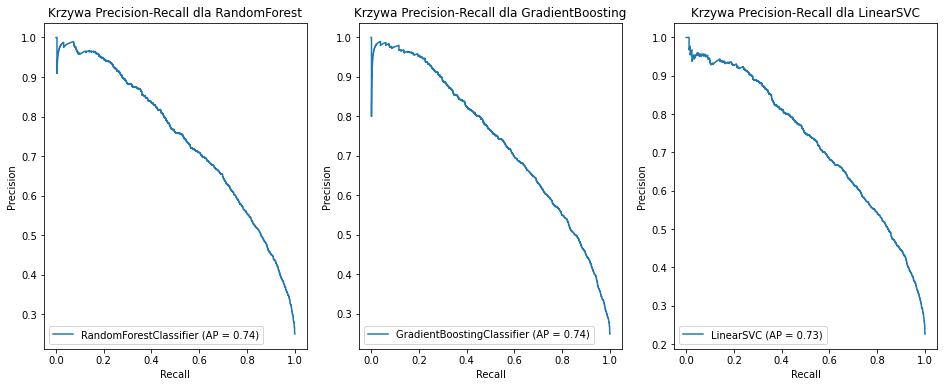

In [23]:
# narysujemy krzywe precision recall dla wybranych modeli
fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
plot_precision_recall_curve(model_rf, data_test, target_test, ax = ax1).ax_.set_title('Krzywa Precision-Recall dla RandomForest')
plot_precision_recall_curve(model_gb, data_test, target_test, ax = ax2).ax_.set_title('Krzywa Precision-Recall dla GradientBoosting')
plot_precision_recall_curve(model_svm, data_test, target_test, ax = ax3).ax_.set_title('Krzywa Precision-Recall dla LinearSVC')

Możemy jeszcze nasze miary przedstawić w postaci wykresu, chociaż średnia prezycja (AP) jest podobna wszędzie, to Gradient Boosting przejawia się jako lepszy model.

#### Confusion matrix

Teoretycznie patrząc na miary precision i recall mogliśmy zauważyć jak wyglądało klasyfikowanie do pozytywnych wartości, ale wykorzystamy jeszcze macierz błędów, aby sprawdzić kolejną z miar.

Text(0.5, 1.0, 'Macierz błędów dla LinearSVC')

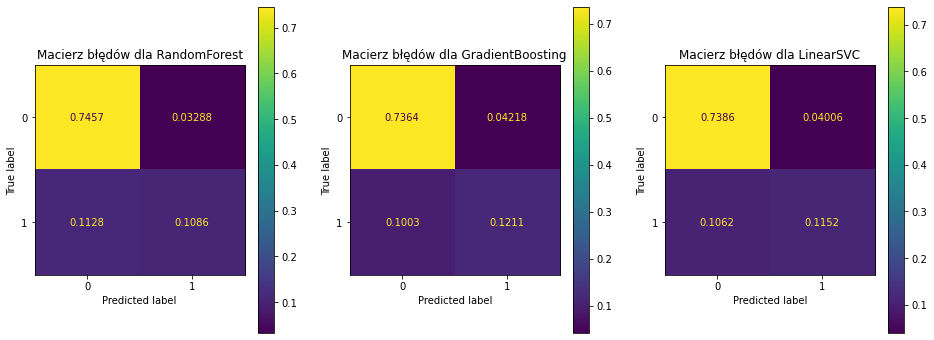

In [26]:
fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
plot_confusion_matrix(model_rf, data_test, target_test, normalize = 'all', values_format=".4g", ax = ax1).ax_.set_title('Macierz błędów dla RandomForest')
plot_confusion_matrix(model_gb, data_test, target_test, normalize = 'all', values_format=".4g", ax = ax2).ax_.set_title('Macierz błędów dla GradientBoosting')
plot_confusion_matrix(model_svm, data_test, target_test, normalize = 'all', values_format=".4g", ax = ax3).ax_.set_title('Macierz błędów dla LinearSVC')

Macierze błędów są moim zdaniem bardzo ładne i łatwo można z nich oczytywać dane. Dowiedzieliśmy się z poprzednich miar, że to Gradient Boosting jest najlepszym modelem i tutaj nic się nie zminiło (gdyż tamte miary bazują na zaklasyfikowaniu danych do zmiennych). Jednak dzięki takim macierzom możemy porównać sklasyfikowane dane i np. Random Forest rzadziej niż inne modele przyporządkował deszcz w dzień niedeszczowy, chociaż z drugiej strony przewidział też częściej brak deszu, gdy ten deszcz był.

#### ROC i AUC

Nie możemy tutaj sprawdzić LinearSVC, jednak chciałabym pokazać krzywe ROC dla pozostałych model, gdy już zostały poczone predykcje prawdopodobieństwa.

In [31]:
print('AUC dla RandomForest:', roc_auc_score(target_test, predict_proba_rf))
print('AUC dla GradientBoosting:', roc_auc_score(target_test, predict_proba_gb))
print('AUC dla XGBoost:', roc_auc_score(target_test, predict_proba_xgb))

AUC dla RandomForest: 0.895923932407934
AUC dla GradientBoosting: 0.8923150812933526
AUC dla XGBoost: 0.890318628679406


Policzyliśmy pole pod krzywą dla trzech modeli (dodałam XGBoost, bo został policzony więc można by go porównać), wszystkie są podobne, największe pole ma jednak Random forest, a najmniejsze XGBoost.

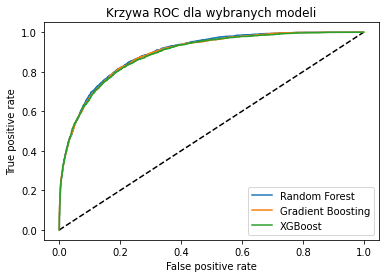

In [35]:
# krzywa ROC dla wybranych modeli
fpr1, tpr1, thresholds1 = roc_curve(target_test, predict_proba_rf)
fpr2, tpr2, thresholds2 = roc_curve(target_test, predict_proba_gb)
fpr3, tpr3, thresholds3 = roc_curve(target_test, predict_proba_xgb)

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1, label='Random Forest')
plt.plot(fpr2, tpr2, label='Gradient Boosting')
plt.plot(fpr3, tpr3, label='XGBoost')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Krzywa ROC dla wybranych modeli')
plt.legend(loc='best')
plt.show()

Jak widzieliśmy wyżej wyniki AUC tak jasne było, że krzywe się na siebie nałożą. Chociaż przy wpatrywaniu się można dotrzeć, że inne kolory przebijają zielony XGBoost, tak lepiej patrzeć na wyniki AUC zamiast tracić wzrok dla tej minimalnej różnicy.

## Bonusowa część zadania

W tej części zadania wykorzystamy model regresji liniowej (komentarz: wedle dokumentacji sklearn regresja liniowa jest bardziej do kategorycznych, a ze wszystkich pozostałych liniowa regresja wydała się jedną z prostrzych do zrozumienia) do przewidywania price w zbiorze Allegro z poprzedniego tygodnia. Wykorzystane zostaną trzy rodzaje kodowania zmiennych kategorycznych - te same co tydzień temu (bądźmy konsekwentni i sprawdźmy czy ich wybór był dobry), a następnie sprawdzona jakość predykcji zostanie za pomocą: $R^2$, RMSE. 

Najpierw wczytamy dane i przypomnimy sobie jakie są tam zmienne kategoryczne do zakodowania. Oczywiście zbiór nie ma braków danych, więc nie będziemy musieli stosować imputacji.

In [43]:
df = pd.read_csv('https://www.dropbox.com/s/360xhh2d9lnaek3/allegro-api-transactions.csv?dl=1')
df.head(5)

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category
0,0,2016-04-03 21:21:08,4753602474,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,59.99,1,997,0,50177,Warszawa,Komputery
1,1,2016-04-03 15:35:26,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,0,12428,Warszawa,"Odzież, Obuwie, Dodatki"
2,2,2016-04-03 14:14:31,4781627074,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,109.90,1,895,0,7389,Leszno,Dom i Ogród
3,3,2016-04-03 19:55:44,4783971474,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",1,1,Matfel1,18.50,0,971,0,15006,Wola Krzysztoporska,Książki i Komiksy
4,4,2016-04-03 18:05:54,4787908274,"['Odzież, Obuwie, Dodatki', 'Ślub i wesele', '...",1,1,PPHU_RICO,19.90,1,950,0,32975,BIAŁYSTOK,"Odzież, Obuwie, Dodatki"


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420020 entries, 0 to 420019
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lp                      420020 non-null  int64  
 1   date                    420020 non-null  object 
 2   item_id                 420020 non-null  int64  
 3   categories              420020 non-null  object 
 4   pay_option_on_delivery  420020 non-null  int64  
 5   pay_option_transfer     420020 non-null  int64  
 6   seller                  420020 non-null  object 
 7   price                   420020 non-null  float64
 8   it_is_allegro_standard  420020 non-null  int64  
 9   it_quantity             420020 non-null  int64  
 10  it_is_brand_zone        420020 non-null  int64  
 11  it_seller_rating        420020 non-null  int64  
 12  it_location             420020 non-null  object 
 13  main_category           420020 non-null  object 
dtypes: float64(1), int64

Mamy 5 kolumn kategorycznych i je trzeba by zakodować. Oczywiście najpierw wypada oczyścić zbiór - np. usunąć kolumny, które nie powinny mieć wpływu na predykcję takie jak lp. Po przejrzeniu danych nie jestem pewna co można a co nie wyrzucić bez większych konsekwencji, m.in. data może wpływać na to, że w danych okresach ludzie wydają więcej. Jednak zakodowanie date może być problematyczne, więc w tym przypadku usunę ją zamiast próbować z nią coś zrobić (chociaż przy głębszej analizie, projektcie albo w pracy raczej bym sprawdziła czy data ma wpływ i jaki najpierw zanim bym ją usunęła).

In [45]:
df = df.drop(['lp', 'date'], axis = 1)

Podzielmy zbiór danych na treningowy i testowy a potem przejdziemy do kodowania.

In [90]:
# dzielimy zbiór na dwie części - z i bez kolumny ze zmienną celu
y = np.array(df['price'])
X = df.drop(['price'],axis=1)

# podział na zbiór treningowy i testowy
df_train, df_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Kodowanie zmiennych kategorycznych

Wykorzystamy:

+ Target Encoder
+ M-Estimate Encoder - w celu porównania z TE
+ Ordinal Encoder (z ciekawości jakie poda wyniki - nie zalecają go używać jak nie mamy ustalonego porządku, więc to taki dodatek do sprawdzenia jaki jest zły albo nie jest)

Chciałam sprawdzić One Hot Encoding, jednak powstałoby za dużo kolumn i nie radzi on sobie jak mamy nową wartość, która nie wystąpiła w treningowym, dlatego zrezygnowałam w trakcie z tej opcji.

In [91]:
# funkcja pomocnicza wykorzystywana do kodowania zmiennych - posiada tylko potrzebne typy kodowania
def encoding(type_encoding : str, target_train = None, target_test = None):

    data_val = ['categories', 'seller','it_location', 'main_category']
    if(type_encoding == 'te'):
        en = ce.TargetEncoder(cols=data_val, return_df=True)
    if(type_encoding == 'ohe'):
        en = ce.OneHotEncoder(cols=data_val, use_cat_names=True, return_df=True)
    if(type_encoding == 'me'):
        en = ce.MEstimateEncoder(cols=data_val, return_df=True)
    if(type_encoding == 'oe'):
        en = ce.OrdinalEncoder(cols=data_val, return_df=True)
        
    data_en_train = df_train.copy()
    data_en_test = df_test.copy()
    encoded_train = en.fit_transform(data_en_train, target_train)
    encoded_test = en.transform(data_en_test, target_test)
    
    return encoded_train, encoded_test

In [92]:
# target endoding
train_te, test_te = encoding('te', y_train, y_test)
# m-estimate ecoding
train_me, test_me = encoding('me', y_train, y_test)
# ordinal encoding
train_oe, test_oe = encoding('oe')

### Regresja liniowa

Jak już wspomniałam wykorzystamy model LinearRegression z pakietu sklearn. A jakość będzie badana na podstawie RMSE i $R^2$.

In [93]:
# tworzenie funkcji pomocniczej do przewidywania zmiennej na podstawie modelu regresji liniowej
def data_reg(data_train, data_test):
    
    model = LinearRegression()
    #trenowanie modelu
    model.fit(data_train, y_train)
    # predykcja 
    predict_class = model.predict(data_test)
    
    return predict_class

In [94]:
# dla te
predict_class_te = data_reg(train_te, test_te)
# dla me
predict_class_me = data_reg(train_me, test_me)
# dla oe
predict_class_oe = data_reg(train_oe, test_oe)

### Wyniki jakości metod encodingu

In [95]:
def metrics_rmse_r2(target_pred):
    rmse = mean_squared_error(y_test, target_pred, squared=False)
    r2 = r2_score(y_test, target_pred)
    return rmse, r2

In [96]:
rmse1, r1 = metrics_rmse_r2(predict_class_te)
rmse2, r2 = metrics_rmse_r2(predict_class_me)
rmse3, r3 = metrics_rmse_r2(predict_class_oe)
pd.DataFrame({'Ecoding Method':['Target Encoder', 'M-Estimate Encoder', 'Ordinal Encoder'],
             'RMSE': [rmse1, rmse2, rmse3], 'R2': [r1, r2, r3]})

,Ecoding Method,RMSE,R2
0,Target Encoder,261.946834,0.180977
1,M-Estimate Encoder,261.960620,0.180891
2,Ordinal Encoder,288.520946,0.006371


M-Estimate i Target są podobnymi do siebie metodami, gdyż M-Estimate jest uproszczoną wersją Target. Nie braliśmy żadnych parametrów do kodowań ani też do modelu regresji (domyślne wartości). Oczywiście dany wynik ukazany w tabeli wyżej jest tylko dla danego wywołania/podziału zbioru (zmiana ziarna zmieni wyniki). Jednak w tym przypadku podobne do siebie metody ME i TE sprawdziły się prawie tak samo - różnice są w RMSE przy 2 liczbie po przecinku, a przy $R^2$ przy 4. Jednak patrząc na te małe różnice to Target Encoding wypadł najlepiej. Natomiast jeśli chodzi o Ordinal Encoder to ma większe RMSE od obu, a miara $R^2$ jest bardzo bliska zeru. Nie jest najlepszy wybór. 

Jeśli chodzi o miarę $R^2$ to wszystkie metody sprawdziły się słabo, wyniki są dość niskie. Miara jest do 1.0, gdzie 1.0 oznacza najlepszy możliwy wynik, a 0.0 oznacza stały model, który nie patrzy na cechy wejściowe przy dopasowywaniu i przewiduje jedną stałą wartość. Dlatego sądzę, że w tym przypadku dobrze byłoby użyć zróżnicowanego kodowania, zastosować inne metody albo pomyśleć czy warto było wyrzucać date.

Jeszcze krótko podsumowując, Target Encoding okazał się tutaj najlepszą metodą, jednak jego wskaźnik $R^2$ wskazuje na to, że nie jest to najlepszy wybór i tak i dobrze byłoby spróbować zrobić coś innego z metodami czy danymi.